## Bag Of n-grams

### Let's first understand how to generate n-grams using CountVectorizer

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
v = CountVectorizer()
v.fit(['Thor Hathodawala is looking for a job'])

CountVectorizer()

In [3]:
v.vocabulary_

{'thor': 5, 'hathodawala': 1, 'is': 2, 'looking': 4, 'for': 0, 'job': 3}

In [4]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 9,
 'hathodawala': 2,
 'is': 4,
 'looking': 7,
 'for': 0,
 'job': 6,
 'thor hathodawala': 10,
 'hathodawala is': 3,
 'is looking': 5,
 'looking for': 8,
 'for job': 1}

In [6]:
v = CountVectorizer(ngram_range=(1,3))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 12,
 'hathodawala': 2,
 'is': 5,
 'looking': 9,
 'for': 0,
 'job': 8,
 'thor hathodawala': 13,
 'hathodawala is': 3,
 'is looking': 6,
 'looking for': 10,
 'for job': 1,
 'thor hathodawala is': 14,
 'hathodawala is looking': 4,
 'is looking for': 7,
 'looking for job': 11}

We will not take a simple collection of text documents, preprocess them to remove stop words, lemmatize etc and then generate bag of 1 grams and 2 grams from it

In [7]:
corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [8]:
!python -m spacy download en_core_web_lg  --quiet


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [12]:
#load english language model and create an object from it
import spacy
nlp = spacy.load("en_core_web_lg")

def preprocess(text):
    filtered_tokens = []
    doc = nlp(text)
    for tok in doc:
        if tok.is_stop or tok.is_punct:
            continue
        filtered_tokens.append(tok.lemma_)
    
    return " ".join(filtered_tokens)
        

In [13]:
preprocess("Thor ate pizza")

'Thor eat pizza'

In [15]:
preprocess("Loki is eating pizza at Chandrettan chayakkada")

'Loki eat pizza Chandrettan chayakkada'

In [16]:
corpus_processed = [preprocess(corp) for corp in corpus]

In [17]:
corpus_processed

['Thor eat pizza', 'Loki tall', 'Loki eat pizza']

In [21]:
v = CountVectorizer(ngram_range = (1,2))
v.fit(corpus_processed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'loki': 2,
 'tall': 6,
 'loki tall': 4,
 'loki eat': 3}

### News Category Classification Problem
Okay now that we know basics of BAG of n grams vectorizer 😎 It is the time to work on a real problem. Here we want to do a news category classification. We will use bag of n-grams and traing a machine learning model that can categorize any news into one of the following categories,

* BUSINESS
* SPORTS
* CRIME
* SCIENCE

### Dataset
Dataset Credits: https://www.kaggle.com/code/hengzheng/news-category-classifier-val-acc-0-65

* This data consists of two columns. - Text - Category
* Text is a news article
* Category can be one of these 4: 'BUSINESS', 'SPORTS', 'CRIME', 'SCIENCE', to keep things simple I trimmed additional categories from the original datase

In [22]:
import pandas as pd

df = pd.read_json('news_dataset.json')
print(df.shape)

df.head()

(12695, 2)


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [23]:
df['category'].value_counts()

BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: category, dtype: int64

### Handle class imbalance
As you can see above, SCIENCE category has almost 1/3rd data samples compared to BUSINESS and SPORTS categories. I initially trained a model without handling the imbalanced I saw a lower f1-score for SCIENCE category. Hence we need to address this imbalanced.

* There are various ways of handling class imbalance which I have discussed in this video: https://www.youtube.com/watch?v=JnlM4yLFNuo

Out of those techniques, I will use undersampling technique here.

* In undersampling, we take a minor class and sample those many samples from other classes, this means we are not utilizing all the data samples for training and in ML world - Not using all the data for training is considered a SIN! 😵 In real life, you are advised to use a technique such as SMOTE so that you can utilize all of your dataset for the training but since this tutorial is more about bag of n-grams then class imbalance itself, I'd go with a simple technique of undersampling.

In [25]:
min_samples = 1381 # we have these many SCIENCE articles and SCIENCE is our minority class

df_business = df[df['category']=='BUSINESS'].sample(min_samples, random_state=1991)
df_sports = df[df.category=="SPORTS"].sample(min_samples, random_state=1991)
df_crime = df[df.category=="CRIME"].sample(min_samples, random_state=1991)
df_science = df[df.category=="SCIENCE"].sample(min_samples, random_state=1991)

In [26]:
df_balanced = pd.concat([df_business,df_sports,df_crime,df_science],axis=0)
df_balanced.category.value_counts()


SCIENCE     1381
BUSINESS    1381
CRIME       1381
SPORTS      1381
Name: category, dtype: int64

### Convert text category to a number



In [27]:
target = {"SCIENCE": 0, "BUSINESS": 1, "CRIME": 2, "SPORTS": 3}

In [29]:
df_balanced['category_num'] = df_balanced['category'].map(target) 

In [30]:
df_balanced

,text,category,category_num
11273,Google Plans To Be Completely Powered By Renew...,BUSINESS,1
4629,The Age of the High-Flying Tech (HFT) Gadgetee...,BUSINESS,1
2488,Chipotle Tweaks Cooking Methods After E. Coli ...,BUSINESS,1
8051,"Ditch the Talking Points, Make Listening Point...",BUSINESS,1
8718,The Internet of Things: 3 Reasons Why Women En...,BUSINESS,1
...,...,...,...
4731,Oceanographers from U.S. and German GEOTRACES ...,SCIENCE,0
3535,How Often Do Solar Eclipses Occur Anyway?,SCIENCE,0
12196,"As World Turns More Slowly, We Face Earthquake...",SCIENCE,0
9958,NASA Spots Snow On Pluto's Mountain Peaks Now ...,SCIENCE,0


### Build a model with original text (no pre processing)

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced.text, df_balanced.category_num, test_size = 0.2,
                                                   random_state = 1991, stratify = df_balanced.category_num)

In [35]:
print(X_train.shape)
X_train.head()

(4419,)


10945    Here's Everything We Know About The New Tesla ...
4653     Cutting Carbon Emissions Could Save Lives Soon...
5358     Scientists Transform Gold Into Something Even ...
3042     Usain Bolt Has Never Run A Full Mile, Accordin...
8171     The California Drought's Alarming Toll On Fore...
Name: text, dtype: object

In [36]:
y_train.value_counts()

1    1105
2    1105
3    1105
0    1104
Name: category_num, dtype: int64

### Attempt 1 : Use 1-gram which is nothing but a Bag Of Words (BOW) model

In [37]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [40]:
#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_bow', CountVectorizer(ngram_range = (1, 1))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.82      0.85       277
           1       0.77      0.90      0.83       276
           2       0.87      0.90      0.89       276
           3       0.89      0.79      0.84       276

    accuracy                           0.85      1105
   macro avg       0.86      0.85      0.85      1105
weighted avg       0.86      0.85      0.85      1105



In [41]:
X_test[:5]

4554     In Galápagos, a Case of Suicide or Murder? Was...
6090     U.S. Figure Skater Adam Rippon Unimpressed By ...
10017    A Melting Antarctica Could Sink The World's Co...
6814     How Earth Changed In 2015: The View From Far A...
7632     The Antares Rocket Failure: So What's Wrong Wi...
Name: text, dtype: object

In [42]:
y_pred[:5]

array([2, 3, 0, 0, 1], dtype=int64)

In [43]:
y_test[:5]

4554     2
6090     3
10017    0
6814     0
7632     0
Name: category_num, dtype: int64

### Attempt 2 : Use 1-gram and bigrams

In [45]:
# Create a pipeline object
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))), ##using the ngram_range parameter
    ('Multi NB', MultinomialNB())
])

In [46]:
clf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer_bow', CountVectorizer(ngram_range=(1, 2))),
                ('Multi NB', MultinomialNB())])

In [47]:
y_pred = clf.predict(X_test)

In [48]:
#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.76      0.83       277
           1       0.69      0.91      0.79       276
           2       0.88      0.87      0.87       276
           3       0.90      0.78      0.83       276

    accuracy                           0.83      1105
   macro avg       0.85      0.83      0.83      1105
weighted avg       0.85      0.83      0.83      1105



### Attempt 3 : Use 1-gram to trigrams

In [49]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_1_3_grams', CountVectorizer(ngram_range = (1, 3))),        #using the ngram_range parameter 
     ('Multi NB', MultinomialNB())         
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.73      0.81       277
           1       0.67      0.92      0.77       276
           2       0.88      0.86      0.87       276
           3       0.90      0.78      0.83       276

    accuracy                           0.82      1105
   macro avg       0.84      0.82      0.82      1105
weighted avg       0.84      0.82      0.82      1105



### Use text pre-processing to remove stop words, punctuations and apply lemmatization
You may wonder, we have not done any text-processing yet to remove stop words, punctuations, apply lemmatization etc. Well we wanted to train the model without any preprocessing first and check the performance. Now we will re-do same thing but with preprocessing of text

In [51]:
df_balanced['processed_text'] = df_balanced['text'].apply(preprocess)

In [52]:
df_balanced

,text,category,category_num,processed_text
11273,Google Plans To Be Completely Powered By Renew...,BUSINESS,1,Google plan completely power renewable Energy ...
4629,The Age of the High-Flying Tech (HFT) Gadgetee...,BUSINESS,1,Age High Flying Tech HFT Gadgeteer Flying Mach...
2488,Chipotle Tweaks Cooking Methods After E. Coli ...,BUSINESS,1,Chipotle Tweaks Cooking Methods E. Coli Outbre...
8051,"Ditch the Talking Points, Make Listening Point...",BUSINESS,1,ditch talk point listening point meeting bunch...
8718,The Internet of Things: 3 Reasons Why Women En...,BUSINESS,1,internet thing 3 reason woman entrepreneur tec...
...,...,...,...,...
4731,Oceanographers from U.S. and German GEOTRACES ...,SCIENCE,0,oceanographer U.S. german GEOTRACES Meet high ...
3535,How Often Do Solar Eclipses Occur Anyway?,SCIENCE,0,Solar eclipse Occur
12196,"As World Turns More Slowly, We Face Earthquake...",SCIENCE,0,World turn slowly face Earthquake Boom scienti...
9958,NASA Spots Snow On Pluto's Mountain Peaks Now ...,SCIENCE,0,NASA spot Snow Pluto Mountain peak need spaces...


### Build a model with pre processed text

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced.processed_text, df_balanced.category_num, test_size=0.2,
                                                   stratify = df_balanced.category_num, random_state = 1991 )

In [55]:
y_train.value_counts()

1    1105
2    1105
3    1105
0    1104
Name: category_num, dtype: int64

In [56]:
y_test.value_counts()

0    277
1    276
2    276
3    276
Name: category_num, dtype: int64

In [57]:
#1. create a pipeline object
clf = Pipeline([
    ('vectorizer_bow', CountVectorizer(ngram_range = (1, 2))),        #using the ngram_range parameter 
    ('Multi NB', MultinomialNB())
])

#2. fit with X_train and y_train
clf.fit(X_train, y_train)


#3. get the predictions for X_test and store it in y_pred
y_pred = clf.predict(X_test)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       277
           1       0.81      0.91      0.86       276
           2       0.88      0.93      0.90       276
           3       0.90      0.85      0.87       276

    accuracy                           0.88      1105
   macro avg       0.88      0.88      0.88      1105
weighted avg       0.88      0.88      0.88      1105



If you compare above classification report for (1,2) gram with the one from unprocessed text, you will find some improvement in the model that uses preprocessed cleaned up text. Hence we can conclude that for this particular problem using preprocessing (removing stop words, lemmatization) is improving the performance of the model

### Plot confusion matrix

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[228,  27,  11,  11],
       [  7, 251,   8,  10],
       [  4,  12, 256,   4],
       [  8,  18,  16, 234]], dtype=int64)

Text(69.0, 0.5, 'Truth')

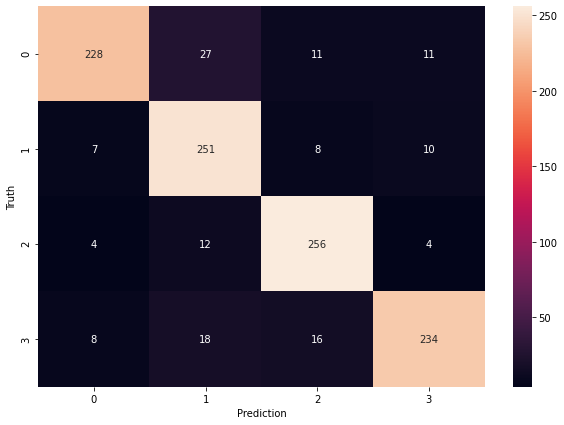

In [60]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')